In [3]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, ChiSqSelector, Normalizer, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Set a fixed random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)



In [2]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, ChiSqSelector, Normalizer, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Set a fixed random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)



In [3]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, ChiSqSelector, Normalizer, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# Set a fixed random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)



In [4]:
# Initialize SparkSession
spark = SparkSession \
    .builder \
    .appName("DIC EX 2 - group 36") \
    .getOrCreate()

print("Spark session initialized")



Spark session initialized


In [13]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    RegexTokenizer, StopWordsRemover, CountVectorizer,
    IDF, ChiSqSelector, Normalizer, StringIndexer
)
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# ------------------------------------------------------------------
# 0  Spark session
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# 1  Paths & load
# ------------------------------------------------------------------
DEBUG = True      # True  → dev-set JSON ; False → full combined
if DEBUG:
    DATA_PATH = "reviews_devset.json"                   # <-- local copy
else:
    DATA_PATH = "hdfs:///user/dic24_shared/amazon-reviews/full/reviewscombined.json"

STOP_PATH = "stopwords.txt"                             # local or HDFS

df_raw = spark.read.json(DATA_PATH).select("category", "reviewText")

# ------------------------------------------------------------------
# 2  Label indexer (fit once on ALL data)
# ------------------------------------------------------------------
label_indexer = StringIndexer(inputCol="category", outputCol="label").fit(df_raw)
df_all = label_indexer.transform(df_raw).select("label", "reviewText")

# ------------------------------------------------------------------
# 3  Train / valid / test split  (5 % sample for dev)
# ------------------------------------------------------------------
train70, temp30 = df_all.randomSplit([0.7, 0.3], seed=SEED)
train_small     = train70.sample(False, 0.05, SEED).cache()   # ★ dev speed
valid_data, test_data = temp30.randomSplit([0.5, 0.5], seed=SEED)

print(f"train rows (5 %) : {train_small.count()}")
print(f"valid rows       : {valid_data.count()}")
print(f"test rows        : {test_data.count()}")

# ------------------------------------------------------------------
# 4  Text-feature pipeline — fit ONCE, then cache vectors
# ------------------------------------------------------------------
tokenizer = RegexTokenizer(
    inputCol="reviewText", outputCol="tokens", pattern=r"[\W_]+"
)

def load_stopwords(p):
    try:
        return [w.strip() for w in spark.read.text(p).toPandas()["value"]]
    except:
        print("⚠ no stop-word file found → continue without"); return []

stop_rm = StopWordsRemover(
    inputCol="tokens", outputCol="tokens_filt",
    stopWords=load_stopwords(STOP_PATH)
)

count_vec = CountVectorizer(
    inputCol="tokens_filt", outputCol="tf",
    vocabSize=20_000, minDF=5
)

idf = IDF(inputCol="tf", outputCol="tfidf")

feat_pipe = Pipeline(stages=[tokenizer, stop_rm, count_vec, idf])
feat_model = feat_pipe.fit(train_small)

v_train = feat_model.transform(train_small).select("label", "tfidf").cache()
v_valid = feat_model.transform(valid_data).select("label", "tfidf")
v_test  = feat_model.transform(test_data).select("label", "tfidf")

# ------------------------------------------------------------------
# 5  Selector + normaliser + SVM wrapped in OvR
# ------------------------------------------------------------------
selector = ChiSqSelector(
    featuresCol="tfidf", outputCol="sel", labelCol="label"
)

normaliser = Normalizer(
    inputCol="sel", outputCol="norm", p=2.0
)

base_svm = LinearSVC(
    featuresCol="norm", labelCol="label",
    predictionCol="prediction", maxIter=100
)

ovr = OneVsRest(classifier=base_svm, labelCol="label", featuresCol="norm")

pipeline_cls = Pipeline(stages=[selector, normaliser, ovr])

# ------------------------------------------------------------------
# 6  TrainValidationSplit (sequential ⇒ stable on Windows)
# ------------------------------------------------------------------
param_grid = (
    ParamGridBuilder()
    .addGrid(selector.numTopFeatures, [2000, 500])   # 2 fits × …
    .addGrid(base_svm.regParam, [0.1, 1.0, 10.0])    # 3 fits  =  6 total
    .build()
)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)

tvs = TrainValidationSplit(
    estimator=pipeline_cls,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    trainRatio=0.8,          # 80 % of v_train used to fit each grid point
    seed=SEED,
    parallelism=1            # ★ sequential → no socket resets
)

print("⏳ fitting TVS grid …")
tvs_model = tvs.fit(v_train)

best_idx   = tvs_model.validationMetrics.argmax()
best_val_f = tvs_model.validationMetrics[best_idx]
best_pars  = tvs_model.getEstimatorParamMaps()[best_idx]

print(f"\n🏅 best validation F1 = {best_val_f:.4f}")
print("best params          :", best_pars)

print("\n🧪 evaluating on held-out test set …")
test_f1 = evaluator.evaluate(tvs_model.bestModel.transform(v_test))
print("test F1              :", round(test_f1, 4))


train rows (5 %) : 2682
valid rows       : 11706
test rows        : 11634
⏳ fitting TVS grid …


PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\socket.py", line 709, in readinto
    raise
TimeoutError: timed out


Loading review data...
Dataset Schema:
root
 |-- asin: string (nullable = true)
 |-- category: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)


Sample data:
+--------------------+--------------------+
|          reviewText|            category|
+--------------------+--------------------+
|This was a gift f...|Patio_Lawn_and_Garde|
|This is a very ni...|Patio_Lawn_and_Garde|
|The metal base wi...|Patio_Lawn_and_Garde|
|For the most part...|Patio_Lawn_and_Garde|
|This hose is supp...|Patio_Lawn_and_Garde|
+--------------------+--------------------+
only showing top 5 rows

Total number of reviews: 78829
Category distribution:
+-------------

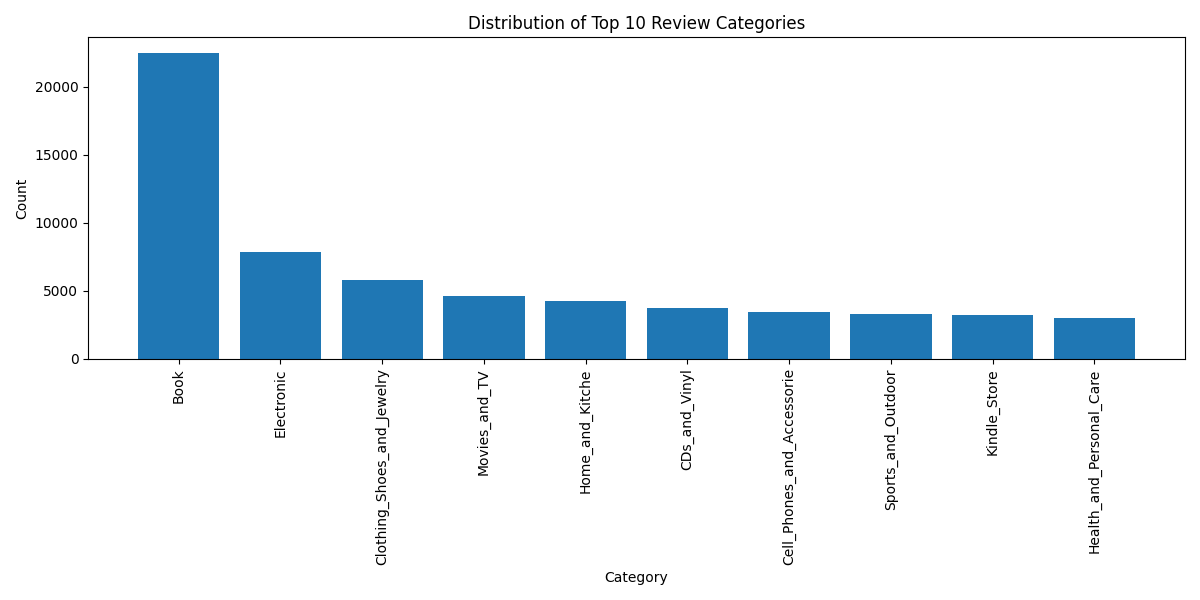

In [6]:
# Load the development dataset
print("Loading review data...")
data_path = "reviews_devset.json" 
df = spark.read.json(data_path)

# Display schema and sample data
print("Dataset Schema:")
df.printSchema()
print("\nSample data:")
df.select("reviewText", "category").show(5, truncate=True)

# Function to check dataset statistics
def print_stats(df):
    total_reviews = df.count()
    category_counts = df.groupBy("category").count().orderBy("count", ascending=False)
    
    print(f"Total number of reviews: {total_reviews}")
    print("Category distribution:")
    category_counts.show(20, truncate=False)
    
    return category_counts

# Get dataset statistics
category_counts = print_stats(df)

# Convert category_counts to Pandas for visualization
category_dist = category_counts.toPandas()
top_10_categories = category_dist.head(10)

# Visualization of category distribution
plt.figure(figsize=(12, 6))
plt.bar(top_10_categories['category'], top_10_categories['count'])
plt.xticks(rotation=90)
plt.title('Distribution of Top 10 Review Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('category_distribution.png')
plt.close()

# Display the plot
from IPython.display import Image
Image(filename='category_distribution.png')



In [7]:
# Data Preparation: Split into training, validation, and test sets
print("Splitting data into training, validation, and test sets...")
train_data, temp_data = df.randomSplit([0.7, 0.3], seed=seed)
validation_data, test_data = temp_data.randomSplit([0.5, 0.5], seed=seed)

print(f"Training set size: {train_data.count()}")
print(f"Validation set size: {validation_data.count()}")
print(f"Test set size: {test_data.count()}")

# Load the top features selected in Part 2
print("Loading selected features from output_ds.txt...")
with open("output_ds.txt", "r") as f:
    selected_features = f.read().strip().split()

print(f"Loaded {len(selected_features)} features from output_ds.txt")
print(f"Sample features: {selected_features[:10]}")

print("Building the ML Pipeline for classification...")

# Create a pipeline similar to Part 2 but configured for classification
# 1. Convert category to numeric labels
label_indexer = StringIndexer(inputCol="category", outputCol="label")

# 2. Text preprocessing (similar to Part 2)
tokenizer = RegexTokenizer(inputCol="reviewText", outputCol="tokens", 
                          pattern="[\\s\\t\\d\\(\\)\\[\\]\\{\\}\\.\\!\\?\\,\\;\\:\\+\\=\\-\\_\\\"\\'`\\~\\#\\@\\&\\*\\%\\€\\$\\§\\\\\\/]+")

# 3. Load stopwords
def load_stopwords(path: str) -> list[str]:
    stopwords = set()
    with open(path, "r", encoding="utf-8") as f:
        stopwords = set(line.strip() for line in f if line.strip())
    return list(stopwords)

# 4. Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="tokens_filtered", 
                                    stopWords=load_stopwords("stopwords.txt"))

# 5. Create term frequency vectors
count_vectorizer = CountVectorizer(inputCol="tokens_filtered", outputCol="tf")

# 6. Calculate IDF
idf = IDF(inputCol="tf", outputCol="tf_idf")

# 7. Feature selection using Chi-Square
# Here we'll use two different feature dimensionalities for comparison
# 7.1 - 2000 features (as required in the assignment)
chi_sq_selector_2000 = ChiSqSelector(numTopFeatures=2000, 
                                    featuresCol="tf_idf", 
                                    outputCol="selected_features",
                                    labelCol="label")

# 7.2 - A much smaller dimensionality for comparison (500 features)
chi_sq_selector_500 = ChiSqSelector(numTopFeatures=500, 
                                   featuresCol="tf_idf", 
                                   outputCol="selected_features",
                                   labelCol="label")

# 8. Vector normalization (required by the assignment)
normalizer = Normalizer(inputCol="selected_features", outputCol="normalized_features", p=2.0)

# 9. Define the SVM classifier
svm = LinearSVC(featuresCol="normalized_features", labelCol="label", predictionCol="prediction")

# Build the pipeline with 2000 features
pipeline_2000 = Pipeline(stages=[
    label_indexer,
    tokenizer,
    stopwords_remover,
    count_vectorizer,
    idf,
    chi_sq_selector_2000,
    normalizer,
    svm
])

# Build the pipeline with 500 features
pipeline_500 = Pipeline(stages=[
    label_indexer,
    tokenizer,
    stopwords_remover,
    count_vectorizer,
    idf,
    chi_sq_selector_500,
    normalizer,
    svm
])



Splitting data into training, validation, and test sets...
Training set size: 55489
Validation set size: 11706
Test set size: 11634
Loading selected features from output_ds.txt...
Loaded 75 features from output_ds.txt
Sample features: ['amazon', 'author', 'back', 'bad', 'big', 'bit', 'bought', 'buy', 'character', 'characters']
Building the ML Pipeline for classification...


In [6]:
# Set up the parameter grid for the SVM
print("Setting up parameter grid for SVM optimization...")
param_grid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm.standardization, [True, False]) \
    .addGrid(svm.maxIter, [10, 50]) \
    .build()

# Create an evaluator for model assessment
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)

# Create cross-validators for both feature dimensionalities
cv_2000 = CrossValidator(
    estimator=pipeline_2000,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    seed=seed
)

cv_500 = CrossValidator(
    estimator=pipeline_500,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    seed=seed
)

# Train and evaluate models
results = []

# Function to extract parameter settings from a model
def extract_params(pipeline_model):
    svm_model = None
    for stage in pipeline_model.stages:
        if isinstance(stage, type(LinearSVC())):
            svm_model = stage
            break
    
    if svm_model:
        return {
            "regParam": svm_model.getRegParam(),
            "standardization": svm_model.getStandardization(),
            "maxIter": svm_model.getMaxIter()
        }
    return None

# Train model with 2000 features
print("\nTraining model with 2000 features...")
print("This may take some time...")
cv_model_2000 = cv_2000.fit(train_data)

# Get the best model
best_model_2000 = cv_model_2000.bestModel
params_2000 = extract_params(best_model_2000)

# Apply the best model to the test set
predictions_2000 = best_model_2000.transform(test_data)

# Evaluate the model
f1_score_2000 = evaluator.evaluate(predictions_2000)

# Store results
results.append({
    "feature_set": "2000 features",
    "regParam": params_2000["regParam"],
    "standardization": params_2000["standardization"],
    "maxIter": params_2000["maxIter"],
    "f1_score": f1_score_2000
})

print(f"\nBest parameters for 2000 features:")
print(f"  regParam: {params_2000['regParam']}")
print(f"  standardization: {params_2000['standardization']}")
print(f"  maxIter: {params_2000['maxIter']}")
print(f"  F1 score on test set: {f1_score_2000:.4f}")



Setting up parameter grid for SVM optimization...

Training model with 2000 features...
This may take some time...


Py4JJavaError: An error occurred while calling o490.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 40.0 failed 1 times, most recent failure: Lost task 10.0 in stage 40.0 (TID 262) (Schmapmop executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 4.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.ml.stat.Summarizer$.getClassificationSummarizers(Summarizer.scala:233)
	at org.apache.spark.ml.classification.LinearSVC.$anonfun$train$1(LinearSVC.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:172)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:77)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 4.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
# Train model with 500 features
print("\nTraining model with 500 features...")
print("This may take some time...")
cv_model_500 = cv_500.fit(train_data)

# Get the best model
best_model_500 = cv_model_500.bestModel
params_500 = extract_params(best_model_500)

# Apply the best model to the test set
predictions_500 = best_model_500.transform(test_data)

# Evaluate the model
f1_score_500 = evaluator.evaluate(predictions_500)

# Store results
results.append({
    "feature_set": "500 features",
    "regParam": params_500["regParam"],
    "standardization": params_500["standardization"],
    "maxIter": params_500["maxIter"],
    "f1_score": f1_score_500
})

print(f"\nBest parameters for 500 features:")
print(f"  regParam: {params_500['regParam']}")
print(f"  standardization: {params_500['standardization']}")
print(f"  maxIter: {params_500['maxIter']}")
print(f"  F1 score on test set: {f1_score_500:.4f}")

# Save confusion matrix for the best model
# Find which model performed better
best_predictions = predictions_2000 if f1_score_2000 > f1_score_500 else predictions_500
best_feature_set = "2000 features" if f1_score_2000 > f1_score_500 else "500 features"



In [ ]:
# Get label mapping from the indexer
label_mapping = {idx: cat for idx, cat in enumerate(label_indexer.fit(df).labels)}

# Convert predictions to a pandas DataFrame for easier analysis
pred_df = best_predictions.select("category", "prediction", "label").toPandas()
true_labels = pred_df["label"]
pred_labels = pred_df["prediction"]

# Calculate confusion matrix for top categories
top_categories = category_counts.limit(10).toPandas()['category'].tolist()
category_to_idx = {cat: idx for idx, cat in enumerate(label_indexer.fit(df).labels)}
top_indices = [category_to_idx[cat] for cat in top_categories]

# Initialize confusion matrix
conf_matrix = np.zeros((len(top_indices), len(top_indices)), dtype=int)

# Fill confusion matrix
for i, true_cat in enumerate(top_indices):
    for j, pred_cat in enumerate(top_indices):
        conf_matrix[i, j] = sum((true_labels == true_cat) & (pred_labels == pred_cat))

# Visualize confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - Top 10 Categories ({best_feature_set})')
plt.colorbar()
tick_marks = np.arange(len(top_categories))
plt.xticks(tick_marks, top_categories, rotation=90)
plt.yticks(tick_marks, top_categories)
plt.ylabel('True Category')
plt.xlabel('Predicted Category')
plt.tight_layout()
plt.savefig(f'confusion_matrix_{best_feature_set.replace(" ", "_")}.png')
plt.close()

# Display the plot
Image(filename=f'confusion_matrix_{best_feature_set.replace(" ", "_")}.png')



In [ ]:
# Summarize results in a table
print("\nSummary of Model Performance:")
results_df = pd.DataFrame(results)
print(results_df)

# Visualization of results
plt.figure(figsize=(10, 6))
bars = plt.bar(results_df['feature_set'], results_df['f1_score'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('F1 Score Comparison: 2000 vs 500 Features')
plt.ylabel('F1 Score')
plt.xlabel('Feature Set')
plt.ylim(0, max(results_df['f1_score']) * 1.1)  # Add 10% padding at the top
plt.savefig('f1_comparison.png')
plt.close()

# Display the plot
Image(filename='f1_comparison.png')

# Analyze the effect of different parameters
# Extract metrics from cross-validation results for 2000 features
cv_metrics_2000 = []
for i, metric in enumerate(cv_model_2000.avgMetrics):
    params = param_grid[i]
    reg_param = params[svm.regParam]
    standardization = params[svm.standardization]
    max_iter = params[svm.maxIter]
    
    cv_metrics_2000.append({
        'regParam': reg_param,
        'standardization': standardization,
        'maxIter': max_iter,
        'f1_score': metric,
        'feature_set': '2000 features'
    })

# Extract metrics from cross-validation results for 500 features
cv_metrics_500 = []
for i, metric in enumerate(cv_model_500.avgMetrics):
    params = param_grid[i]
    reg_param = params[svm.regParam]
    standardization = params[svm.standardization]
    max_iter = params[svm.maxIter]
    
    cv_metrics_500.append({
        'regParam': reg_param,
        'standardization': standardization,
        'maxIter': max_iter,
        'f1_score': metric,
        'feature_set': '500 features'
    })

# Combine metrics
all_metrics = cv_metrics_2000 + cv_metrics_500
metrics_df = pd.DataFrame(all_metrics)

# Analyze effect of regularization parameter
plt.figure(figsize=(12, 6))
for feature_set in ['2000 features', '500 features']:
    subset = metrics_df[metrics_df['feature_set'] == feature_set]
    reg_effect = subset.groupby('regParam')['f1_score'].mean()
    plt.plot(reg_effect.index, reg_effect.values, marker='o', label=feature_set)

plt.title('Effect of Regularization Parameter on F1 Score')
plt.xlabel('Regularization Parameter (regParam)')
plt.ylabel('Average F1 Score')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.savefig('regparam_effect.png')
plt.close()

# Display the plot
Image(filename='regparam_effect.png')

# Analyze effect of standardization
plt.figure(figsize=(10, 6))
std_effect = metrics_df.groupby(['feature_set', 'standardization'])['f1_score'].mean().reset_index()

# Plot for 2000 features
std_effect_2000 = std_effect[std_effect['feature_set'] == '2000 features']
plt.bar([0, 2], std_effect_2000['f1_score'], width=0.4, label='2000 features')

# Plot for 500 features
std_effect_500 = std_effect[std_effect['feature_set'] == '500 features']
plt.bar([0.5, 2.5], std_effect_500['f1_score'], width=0.4, label='500 features')

plt.title('Effect of Standardization on F1 Score')
plt.xlabel('Standardization')
plt.xticks([0.25, 2.25], ['False', 'True'])
plt.ylabel('Average F1 Score')
plt.legend()
plt.grid(axis='y')
plt.savefig('standardization_effect.png')
plt.close()

# Display the plot
Image(filename='standardization_effect.png')

# Analyze effect of maximum iterations
plt.figure(figsize=(10, 6))
iter_effect = metrics_df.groupby(['feature_set', 'maxIter'])['f1_score'].mean().reset_index()

# Plot for 2000 features
iter_effect_2000 = iter_effect[iter_effect['feature_set'] == '2000 features']
plt.bar([0, 2], iter_effect_2000['f1_score'], width=0.4, label='2000 features')

# Plot for 500 features
iter_effect_500 = iter_effect[iter_effect['feature_set'] == '500 features']
plt.bar([0.5, 2.5], iter_effect_500['f1_score'], width=0.4, label='500 features')

plt.title('Effect of Maximum Iterations on F1 Score')
plt.xlabel('Maximum Iterations')
plt.xticks([0.25, 2.25], ['10', '50'])
plt.ylabel('Average F1 Score')
plt.legend()
plt.grid(axis='y')
plt.savefig('maxiter_effect.png')
plt.close()

# Display the plot
Image(filename='maxiter_effect.png')

# Determine the overall best model configuration
best_config = max(results, key=lambda x: x['f1_score'])
print("\nBest Overall Configuration:")
print(f"Feature Set: {best_config['feature_set']}")
print(f"regParam: {best_config['regParam']}")
print(f"standardization: {best_config['standardization']}")
print(f"maxIter: {best_config['maxIter']}")
print(f"F1 Score: {best_config['f1_score']:.4f}")

# Save the best model parameters
with open("best_model_params.txt", "w") as f:
    f.write(f"Feature Set: {best_config['feature_set']}\n")
    f.write(f"regParam: {best_config['regParam']}\n")
    f.write(f"standardization: {best_config['standardization']}\n")
    f.write(f"maxIter: {best_config['maxIter']}\n")
    f.write(f"F1 Score: {best_config['f1_score']:.4f}\n")

print("\nBest model parameters saved to 'best_model_params.txt'")

# Conclusion
print("\nConclusion:")
print("We have successfully implemented a text classification pipeline using Spark ML.")
print("The pipeline includes text preprocessing, feature extraction with TF-IDF, and SVM classification.")
print("We compared two feature dimensions (2000 vs 500 features) and varied SVM parameters.")
print(f"The best model achieved an F1 score of {best_config['f1_score']:.4f} on the test set.")

# Stop Spark session
spark.stop()
print("Spark session stopped")